## **Super Dead Leaves**

-------------

The **Super Dead Leaves** (SDL) pattern is an extension of the texture reproduction fidelity chart _Dead Leaves_ [1] defined in the international standards ISO-19567-2 [2] and IEEE-1858 [3]. In this test pattern the overlapping random circles have been replaced by more complex shapes generated using Johan Gielis\' _superformula_ [4]. The _superformula_ is a generalization of the superellipse that can generate a wide variety of geometric shapes with multiple lobes that resemble real leaves. To generate the pattern, a large number of shapes are sampled and "stacked" underneath the previously generated shapes until all pixels are covered.

To further increase the variety and unpredictability of the shapes, the _superformula_ parameters in the SDL can be randomly sampled separately in each lobe to generate even more organic-looking shapes. Following the Dead Leaves model, the area of each shape matches the area of a circle with a radius sampled from a power law distribution with exponent -3 (scale invariant). The center of the shapes are sampled with a uniform distribution on the image plane (the center can be located outside the image).

The _superformula_ equation [4], in polar coordinates, is given by:

\begin{equation}
r(\theta) = \left( \left| \frac{\cos\left(\frac{m \theta}{4}\right)}{a} \right|^{n_2} + \left| \frac{\sin\left(\frac{m \theta}{4}\right)}{b} \right|^{n_3} \right)^{-\frac{1}{n_1}}
\end{equation}

where:
- $r(\theta)$ defines the radial distance as a function of the polar angle $\theta$.
- $m$ determines the number of lobes (periodic symmetry).
- $n_1$ adjusts the overall roundness or spikiness of the shape (smaller values yield more angular shapes).
- $n_2$ and $n_3$ influence the shape's curvature and the sharpness or smoothness of the lobes.
- $a$ and $b$ control the scaling along the $x$ and $y$ axes (fixed to 1).

In the SDL, the parameters \($n_1$, $n_2$, $n_3$\) can be randomly perturbed in each one of the $m$ lobes to generate unique and varied shapes that resemble biological forms.

The ultimate objective of the SDL pattern is to test the performance of non-linear image processing algorithms based on machine-learning techniques. High-resolution, noise-free realizations of the SDL can be computationally  degraded to reproduce images acquired with a real imaging device. These images can then be post-processed with denoising and super-resolution algorithms to try to recover the original ground truth image. Methods developed to process the Dead Leaves phantom [5] can be used for a full-reference analysis of the information recovered in the post-processing.

  - [1] Cao, Guichard and Hornung, "Dead leaves model for measuring texture quality on a digital camera" in SPIE Digital Photography VI, vol. 7537, p. 126-133 (2010)
  - [2] ISO/TS 19567-2:2019, "Photography — Digital cameras, Part 2: Texture analysis using stochastic pattern" (2019)
  - [3] IEEE 1858-2023, "IEEE Standard for Camera Phone Image Quality (CPIQ)" (2023) 
  - [4] Johan Gielis. "A generic geometric transformation that unifies a wide range of natural and abstract shapes." American journal of botany 90, p. 333-338 (2003)
  - [5] Kirk, L., Herzer, P., Artmann, U., and Kunz, D., "Description of texture loss using the dead leaves target: current issues and a new intrinsic approach." SPIE Digital Photography X, 9023, p. 112–120 (2014)

-------------

**Author**: Andreu Badal (Andreu.Badal-Soler (at) fda.hhs.gov)

**Date**: 2024/12/10

**Disclaimer**
This software and documentation (the "Software") were developed at the US Food and Drug Administration (FDA) by employees of the Federal Government in the course of their official duties. Pursuant to Title 17, Section 105 of the United States Code, this work is not subject to copyright protection and is in the public domain. Permission is hereby granted, free of charge, to any person obtaining a copy of the Software, to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, or sell copies of the Software or derivatives, and to permit persons to whom the Software is furnished to do so. FDA assumes no responsibility whatsoever for use by other parties of the Software, its source code, documentation or compiled executables, and makes no guarantees, expressed or implied, about its quality, reliability, or any other characteristic. Further, use of this code in no way implies endorsement by the FDA or confers any advantage in regulatory decisions. Although this software can be redistributed and/or modified freely, we ask that any derivative works bear some notice that they are derived from it, and any modified versions bear some notice that they have been modified.

In [11]:
# - Import external libraries:
#%pip install --upgrade pip
%pip install -q matplotlib scipy scikit-image

import numpy as np
import matplotlib.pyplot as plt
from time import time

# Import my new library:
from src.SuperDeadLeaves import SuperDeadLeaves

Note: you may need to restart the kernel to use updated packages.


 ** Generating a Superformula shape with 7 lobes (randomization=True):



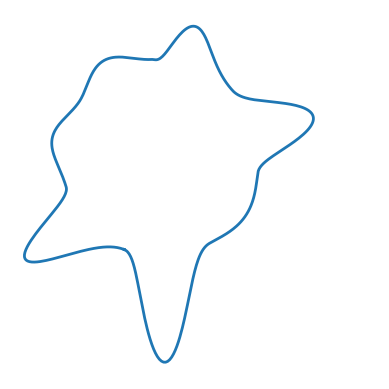

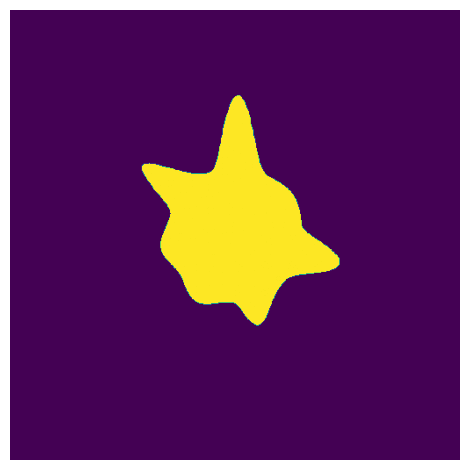

In [12]:
# - Generate a sample random shape as a polygon and a bitmap mask:
num_lobes = 7
randomization = True   # Set to False to generate a regular polygon

print(f" ** Generating a Superformula shape with {num_lobes} lobes (randomization={randomization}):\n")

SDL = SuperDeadLeaves(polygon_range=[num_lobes, num_lobes], randomized=randomization)

X, Y = SDL.generate_polygon()

plt.plot(X, Y, linewidth=2)
plt.axis('square')
plt.axis('off')
plt.savefig('polygon.png')
plt.show()    

# - Generate a bitmap mask for the sample shape (in a random orientation):
shape_mask = SDL.generate_mask_from_polygon(X, Y)

plt.figure()
plt.imshow(shape_mask, vmin=0, vmax=256)
plt.axis('off')
plt.tight_layout()
plt.show()

 ** Generating a "Super Dead Leaves" pattern chart (seed=92230):
    - Parameters: image_size = [360, 640] pixels, num_samples=100000, rmin=0.0025, rmax=0.2, polygon_range=[3, 8], randomized=True

 - ... 10000 of 100000 shapes (10.0%):	 uncovered pixels = 26.17120% ;	 Time: 15.93 s ;	 ETA: 143.37 s = 2.39 min ...
 - ... 20000 of 100000 shapes (20.0%):	 uncovered pixels =  6.70030% ;	 Time: 27.494 s ;	 ETA: 109.98 s = 1.833 min ...
 - ... 30000 of 100000 shapes (30.0%):	 uncovered pixels =  1.35634% ;	 Time: 40.809 s ;	 ETA: 95.222 s = 1.587 min ...
 - ... 40000 of 100000 shapes (40.0%):	 uncovered pixels =  0.35807% ;	 Time: 51.839 s ;	 ETA: 77.759 s = 1.296 min ...
 - Final amount of shapes stacked on the chart: 41619. Uncovered pixels set to background (0.5): 0 (   0.0%)

     [generate_chart]: img.shape=(360, 640) , mean(img)=0.496 , max(img)=1.0 , min(img)=8.25e-06 , img[180,320]=0.355 , type=<class 'numpy.float32'>

 - Saving the chart image in file "SDL_92230_3-8_rmin0.0025_rmax0

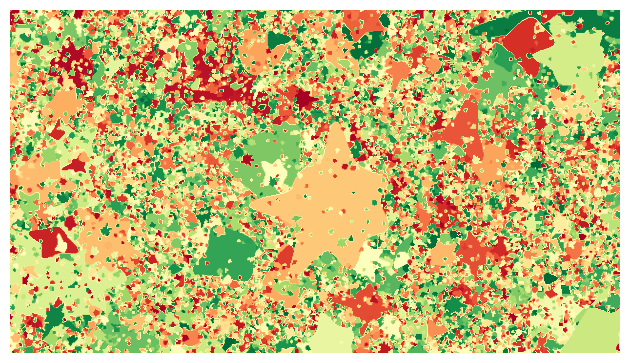


 - Time used to generate the SDL image: 53.645 s = 0.8941 min


In [13]:
# Generate a Super Dead Leaves (SDL) pattern with overlapping random shapes:
image_size = [360, 640]  # Recommended size: [4096, 4096] (might take a long time)
seed = np.random.randint(1e4, 1e5)  # Use None for a random initialization
rmin = 0.0025  # To comply with ISO-19567-2, rmin should be smaller than a pixel (1/image_size) in the final version of the chart
rmax = 0.2
num_samples   = 100000   # Use a large enough value to be sure the entire image is covered (generation will automatically stop)
polygons = [3,8]   # Range of lobes in the generated shapes (use 2 for circles)       
randomization = True

print(f" ** Generating a \"Super Dead Leaves\" pattern chart (seed={seed}):")
print(f"    - Parameters: image_size = {image_size} pixels, num_samples={num_samples}, rmin={rmin}, rmax={rmax}, polygon_range={polygons}, randomized={randomization}\n")
time0 = time()

SDL = SuperDeadLeaves(image_size=image_size, seed=seed, polygon_range=polygons, randomized=randomization, contrast=1.0, rmin=rmin, rmax=rmax, num_samples_chart=num_samples, borderFree=False)
chart = SDL.generate_chart(f'SDL_{seed}_{SDL.polygon_range[0]}-{SDL.polygon_range[1]}_rmin{SDL.rmin}_rmax{SDL.rmax}_{image_size[0]}x{image_size[1]}.tif')    
SDL.report()  # Report the chart parameters in the class instance internal variables

plt.figure()
plt.imshow(chart, cmap='RdYlGn', vmin=0, vmax=1)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n - Time used to generate the SDL image: {(time()-time0):.5} s = {(time()-time0)/60:.4} min")

 ** Generating a traditional "Dead Leaves" chart with circles (seed=92230):

 - ... 10000 of 100000 shapes (10.0%):	 uncovered pixels = 28.84454% ;	 Time: 11.862 s ;	 ETA: 106.76 s = 1.779 min ...
 - ... 20000 of 100000 shapes (20.0%):	 uncovered pixels =  8.97217% ;	 Time: 18.262 s ;	 ETA: 73.047 s = 1.217 min ...
 - ... 30000 of 100000 shapes (30.0%):	 uncovered pixels =  2.77032% ;	 Time: 24.523 s ;	 ETA: 57.221 s = 0.9537 min ...
 - ... 40000 of 100000 shapes (40.0%):	 uncovered pixels =  0.68970% ;	 Time: 34.797 s ;	 ETA: 52.195 s = 0.8699 min ...
 - ... 50000 of 100000 shapes (50.0%):	 uncovered pixels =  0.18989% ;	 Time: 42.856 s ;	 ETA: 42.856 s = 0.7143 min ...
 - Final amount of shapes stacked on the chart: 51885. Uncovered pixels set to background (0.5): 0 (   0.0%)

     [generate_chart]: img.shape=(360, 640) , mean(img)=0.503 , max(img)=1.0 , min(img)=0.000103 , img[180,320]=0.697 , type=<class 'numpy.float32'>

 - Saving the chart image in file "DL_92230_rmin0.0025_rmax0

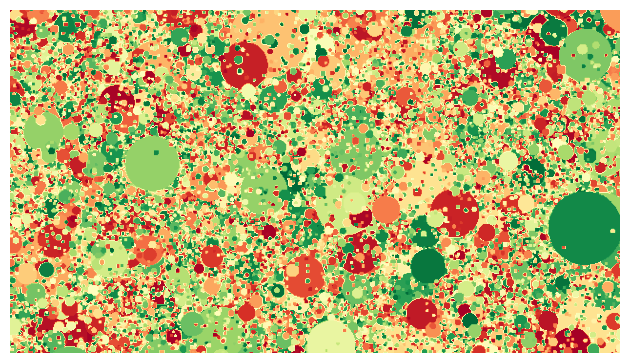


 - Time used to generate the DL image: 44.392 s = 0.7399 min


In [14]:
# - Generate a traditional Dead Leaves (DL) chart with circles (compatible with ISO-19567-2 and IEEE-1858):
time0 = time()
polygons = [0,0]
randomization = False
print(f" ** Generating a traditional \"Dead Leaves\" chart with circles (seed={seed}):\n")

DL = SuperDeadLeaves(image_size=image_size, seed=seed, polygon_range=polygons, randomized=randomization, rmin=rmin, num_samples_chart=num_samples)   # Generate only circles
chart_DL = DL.generate_chart(f'DL_{seed}_rmin{DL.rmin}_rmax{DL.rmax}_{image_size[0]}x{image_size[1]}.tif')
DL.report()  # Report the chart parameters in the class instance internal variables

plt.figure()
plt.imshow(chart_DL, cmap='RdYlGn', vmin=0, vmax=1)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n - Time used to generate the DL image: {(time()-time0):.5} s = {(time()-time0)/60:.4} min")

 ** Generating a "Super Dead Leaves" chart with deformed circles made using the randomized superformula with m=2 (seed=92230):

 - ... 10000 of 100000 shapes (10.0%):	 uncovered pixels = 27.36274% ;	 Time: 17.091 s ;	 ETA: 153.82 s = 2.564 min ...
 - ... 20000 of 100000 shapes (20.0%):	 uncovered pixels =  5.93126% ;	 Time: 29.069 s ;	 ETA: 116.28 s = 1.938 min ...
 - ... 30000 of 100000 shapes (30.0%):	 uncovered pixels =  1.48112% ;	 Time: 39.276 s ;	 ETA: 91.644 s = 1.527 min ...
 - ... 40000 of 100000 shapes (40.0%):	 uncovered pixels =  0.45776% ;	 Time: 51.791 s ;	 ETA: 77.687 s = 1.295 min ...
 - Final amount of shapes stacked on the chart: 41408. Uncovered pixels set to background (0.5): 0 (   0.0%)

     [generate_chart]: img.shape=(360, 640) , mean(img)=0.491 , max(img)=1.0 , min(img)=6.41e-05 , img[180,320]=0.697 , type=<class 'numpy.float32'>

 - Saving the chart image in file "SDL2_92230_rmin0.0025_rmax0.2_360x640.tif".

 ** [REPORT] SuperDeadLeaves class instance variable

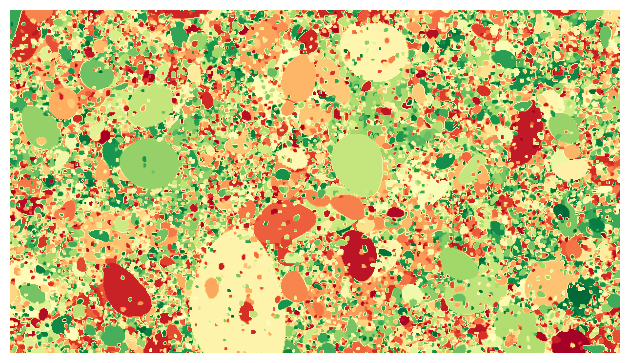


 - Time used to generate the SDL image: 53.457 s = 0.8909 min


In [15]:
# - Generate a SDL chart that looks like a DL chart with deformed circles, generated with the randomized superformula with m=2:
time0 = time()
polygons = [2,2]
randomization = True
print(f" ** Generating a \"Super Dead Leaves\" chart with deformed circles made using the randomized superformula with m=2 (seed={seed}):\n")

SDL2 = SuperDeadLeaves(image_size=image_size, seed=seed, polygon_range=[2,2], randomized=randomization, rmin=rmin, num_samples_chart=num_samples)   # Generate only circles
chart_SDL2 = SDL2.generate_chart(f'SDL2_{seed}_rmin{DL.rmin}_rmax{DL.rmax}_{image_size[0]}x{image_size[1]}.tif')
SDL2.report()  # Report the chart parameters in the class instance internal variables

plt.figure()
plt.imshow(chart_SDL2, cmap='RdYlGn', vmin=0, vmax=1)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n - Time used to generate the SDL image: {(time()-time0):.5} s = {(time()-time0)/60:.4} min")

 ** Generating a cell pattern based on the "Super Dead Leaves" model:
    - Parameters: image_size = [360, 640] pixels, seed=92230, contrast=0.5, num_samples=250, rmin=0.03, rmax=0.3
                  polygon_range=[3, 8], randomized=True, borderFree=True

... 31 shapes of 250 (12.4%) added to the chart (loop iteration 500)...
... 39 shapes of 250 (15.6%) added to the chart (loop iteration 1000)...
... 42 shapes of 250 (16.8%) added to the chart (loop iteration 1500)...
... 43 shapes of 250 (17.2%) added to the chart (loop iteration 2000)...
... 45 shapes of 250 (18.0%) added to the chart (loop iteration 2500)...
 - Saving the chart image in file "cell_SDL_92230_2-5_rmin0.03_rmax0.3_360x640.tif".

  - Number of cells included in the chart: 45


 ** [REPORT] SuperDeadLeaves class instance variables:
       - rng = Generator(PCG64),	 type=<class 'numpy.random._generator.Generator'>
       - image_size = [360, 640],	 type=<class 'list'>
       - polygon_range = [2, 5],	 type=<class 'list'

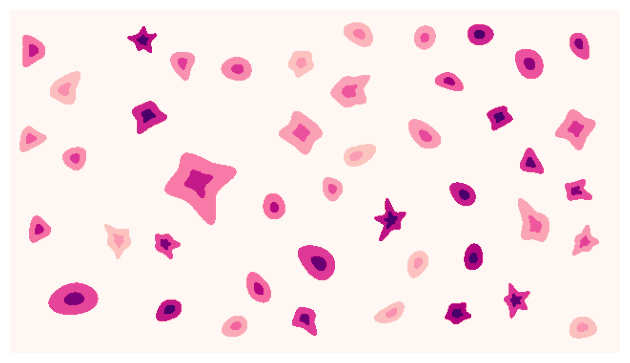


 - Time used to generate the cell-SDL image: 7.84 s


In [16]:
# Simple extension of the SDL to generate a pattern that resembles cells in a cytology slide (eg, a liquid-based pap test):
time0 = time()
cSDL = SuperDeadLeaves(image_size=image_size, seed=seed, polygon_range=[2,5], randomized=True, borderFree=True)

cSDL.num_samples_chart = 250
cSDL.contrast = 0.5
cSDL.rmin = 0.03
cSDL.rmax = 0.30
cSDL.variability_n1 = 0.3
cSDL.background_color = 0.0

print(f" ** Generating a cell pattern based on the \"Super Dead Leaves\" model:")
print(f"    - Parameters: image_size = {image_size} pixels, seed={seed}, contrast={cSDL.contrast}, num_samples={cSDL.num_samples_chart}, rmin={cSDL.rmin}, rmax={cSDL.rmax}")
print(f"                  polygon_range={SDL.polygon_range}, randomized={cSDL.randomized}, borderFree={cSDL.borderFree}\n")

fname = f'cell_SDL_{seed}_{cSDL.polygon_range[0]}-{cSDL.polygon_range[1]}_rmin{cSDL.rmin}_rmax{cSDL.rmax}_{image_size[0]}x{image_size[1]}.tif'
cell_chart = cSDL.generate_cell_chart(cell_spacing_area_factor=3.5, cell_nucleus_area_factor=0.15, cell_nucleus_intensity=1.5, filename=fname)
cSDL.report()  # Report the chart parameters in the class instance internal variables

plt.figure()
plt.imshow(cell_chart, cmap='RdPu', vmin=0, vmax=1)
plt.axis('off')
plt.tight_layout()
plt.show()     

print(f"\n - Time used to generate the cell-SDL image: {(time()-time0):.3} s")

In [17]:
# To create a GIF animation showing the step-by-step creation of the chart, uncomment all 
# the lines in the SuperDeadLeaves.py marked with the comment !!GIF!!

#import imageio
#fps = 3
#imageio.mimsave(f'cell_SDL_{seed}_animation.gif', GIF_frames, fps=fps)
#print(f'Creating GIF animation with {len(GIF_frames)} frames at {fps} fps.')